# Analysis on Kickstarter

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from rdd import rdd
# Show all columns
pd.set_option('display.max_columns', None)


In [2]:
# Load the data
df = pd.read_json('../data/creator_first_project.json', lines = True)
df.shape

(328653, 134)

# Visualize the Data

Text(0.5, 1.0, 'New Kickstarter Creators by Year')

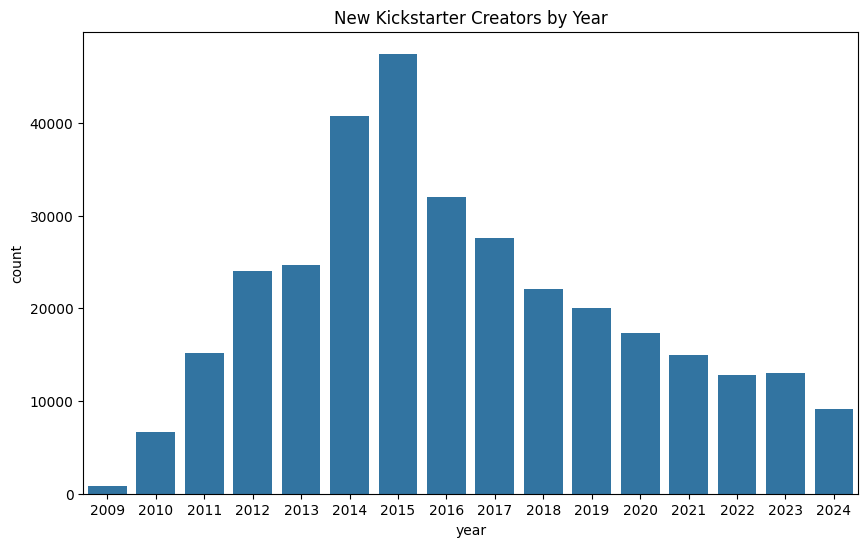

In [3]:
# New Kickstarter Creators by Year
df['year'] = df['launched_at'].dt.year
df['month'] = df['launched_at'].dt.month

# Plot
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='year')
plt.title('New Kickstarter Creators by Year')

Check first project statistics

In [4]:
# Convert some key statistics to integers
df['spotlight'] = df['spotlight'].astype(int)

# Replace missing with zeros for prelaunch_activated
df['prelaunch_activated'] = df['prelaunch_activated'].fillna(0)

In [5]:
print(df[['goal', 'pledged', 'staff_pick', 'backers_count', 'spotlight', 'prelaunch_activated']].describe().apply(lambda s: s.apply('{0:.2f}'.format)))

                goal       pledged staff_pick backers_count  spotlight  \
count      328653.00     328653.00  321020.00     328653.00  328653.00   
mean        55322.02      30048.42       0.11        129.73       0.50   
std       2102742.08    1318562.73       0.32        942.75       0.50   
min             1.00          0.00       0.00          0.00       0.00   
25%          2000.00         75.00       0.00          3.00       0.00   
50%          5000.00       1260.00       0.00         21.00       0.00   
75%         15000.00       6383.01       0.00         77.00       1.00   
max    1000000000.00  481621841.00       1.00     219382.00       1.00   

      prelaunch_activated  
count           328653.00  
mean                 0.08  
std                  0.28  
min                  0.00  
25%                  0.00  
50%                  0.00  
75%                  0.00  
max                  1.00  


Define the Discontinuity

In [6]:
# Create Discontinuity Columns
df['percent_to_goal'] = df['pledged'] / df['goal']
df['dollars_to_goal'] = df['goal'] - df['pledged']

Plot the density near the discontinuity

In [7]:
# Create a plotting dataframe
# Define the cutoff point
cutoff = 1  # Adjust this value based on your specific cutoff criteria

# Create a copy of the DataFrame
plotting_df = df.copy()
# Remove outliers
plotting_df = plotting_df[(plotting_df['percent_to_goal'] <= 2) & (plotting_df['percent_to_goal'] > 0)]

# Split data into left and right of the cutoff
left_df = plotting_df[plotting_df['percent_to_goal'] < cutoff]
right_df = plotting_df[plotting_df['percent_to_goal'] >= cutoff]

# Bin each subset separately
left_df['percent_to_goal_binned'] = pd.cut(left_df['percent_to_goal'], bins=20)
right_df['percent_to_goal_binned'] = pd.cut(right_df['percent_to_goal'], bins=20)

# Aggregate the binned data for each subset
left_binned_data = left_df.groupby('percent_to_goal_binned').agg({
    'total_successful_after_first': 'mean',
    'total_failed_after_first': 'mean',
    'total_canceled_after_first': 'mean',
    'total_raised_after_first': 'sum',
    'total_campaigns_after_first': 'mean',
    'percent_to_goal': 'size'  # Counts the number of observations in each bin
}).reset_index().rename(columns={'percent_to_goal': 'n_obs'})
right_binned_data = right_df.groupby('percent_to_goal_binned').agg({
    'total_successful_after_first': 'mean',
    'total_failed_after_first': 'mean',
    'total_canceled_after_first': 'mean',
    'total_raised_after_first': 'sum',
    'total_campaigns_after_first': 'mean',
    'percent_to_goal': 'size'  # Counts the number of observations in each bin
}).reset_index().rename(columns={'percent_to_goal': 'n_obs'})

# Add a midpoint for each bin for both left and right data
left_binned_data['percent_to_goal'] = left_binned_data['percent_to_goal_binned'].apply(lambda interval: interval.mid)
right_binned_data['percent_to_goal'] = right_binned_data['percent_to_goal_binned'].apply(lambda interval: interval.mid)

# Combine the binned data for both sides of the cutoff
plotting_df = pd.concat([left_binned_data, right_binned_data], ignore_index=True)

# Add Threshold Column
plotting_df['threshold'] = plotting_df['percent_to_goal'] >= cutoff

C:\Users\d0tam\AppData\Local\Temp\ipykernel_34488\1716103271.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  left_df['percent_to_goal_binned'] = pd.cut(left_df['percent_to_goal'], bins=20)
C:\Users\d0tam\AppData\Local\Temp\ipykernel_34488\1716103271.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  right_df['percent_to_goal_binned'] = pd.cut(right_df['percent_to_goal'], bins=20)
C:\Users\d0tam\AppData\Local\Temp\ipykernel_34488\1716103271.py:19: FutureWarning: The default of observed=False is deprec

c:\Users\d0tam\kickstarter-JMP\.venv\Lib\site-packages\seaborn\distributions.py:413: UserWarning: `bins` cannot be 'auto' when using weights. Setting `bins=10`, but you will likely want to adjust.
  warnings.warn(msg, UserWarning)


<Axes: xlabel='percent_to_goal', ylabel='Count'>

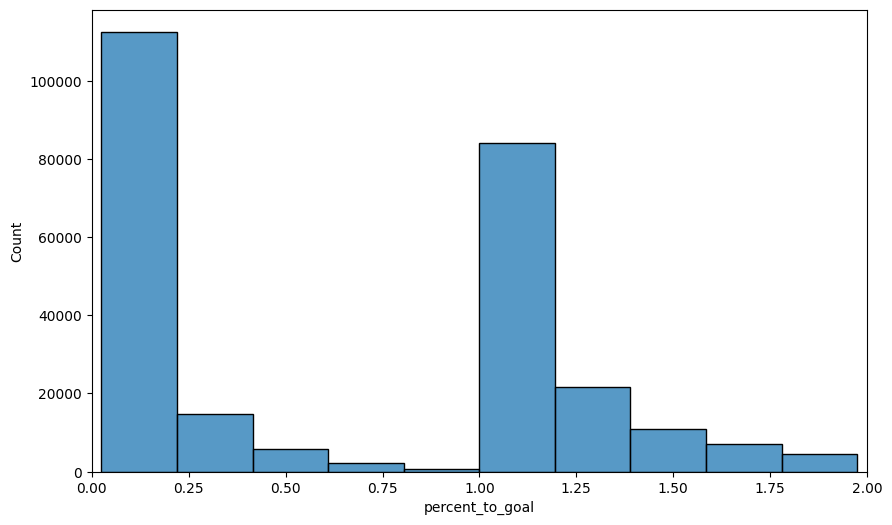

In [8]:
# Plot percent to goal on x axis and total number of projects on y axis
plt.figure(figsize=(10,6))
plt.xlim(0, 2)
sns.histplot(data=plotting_df, x='percent_to_goal', weights = 'n_obs')

Text(0.5, 0, 'Percent to Goal')

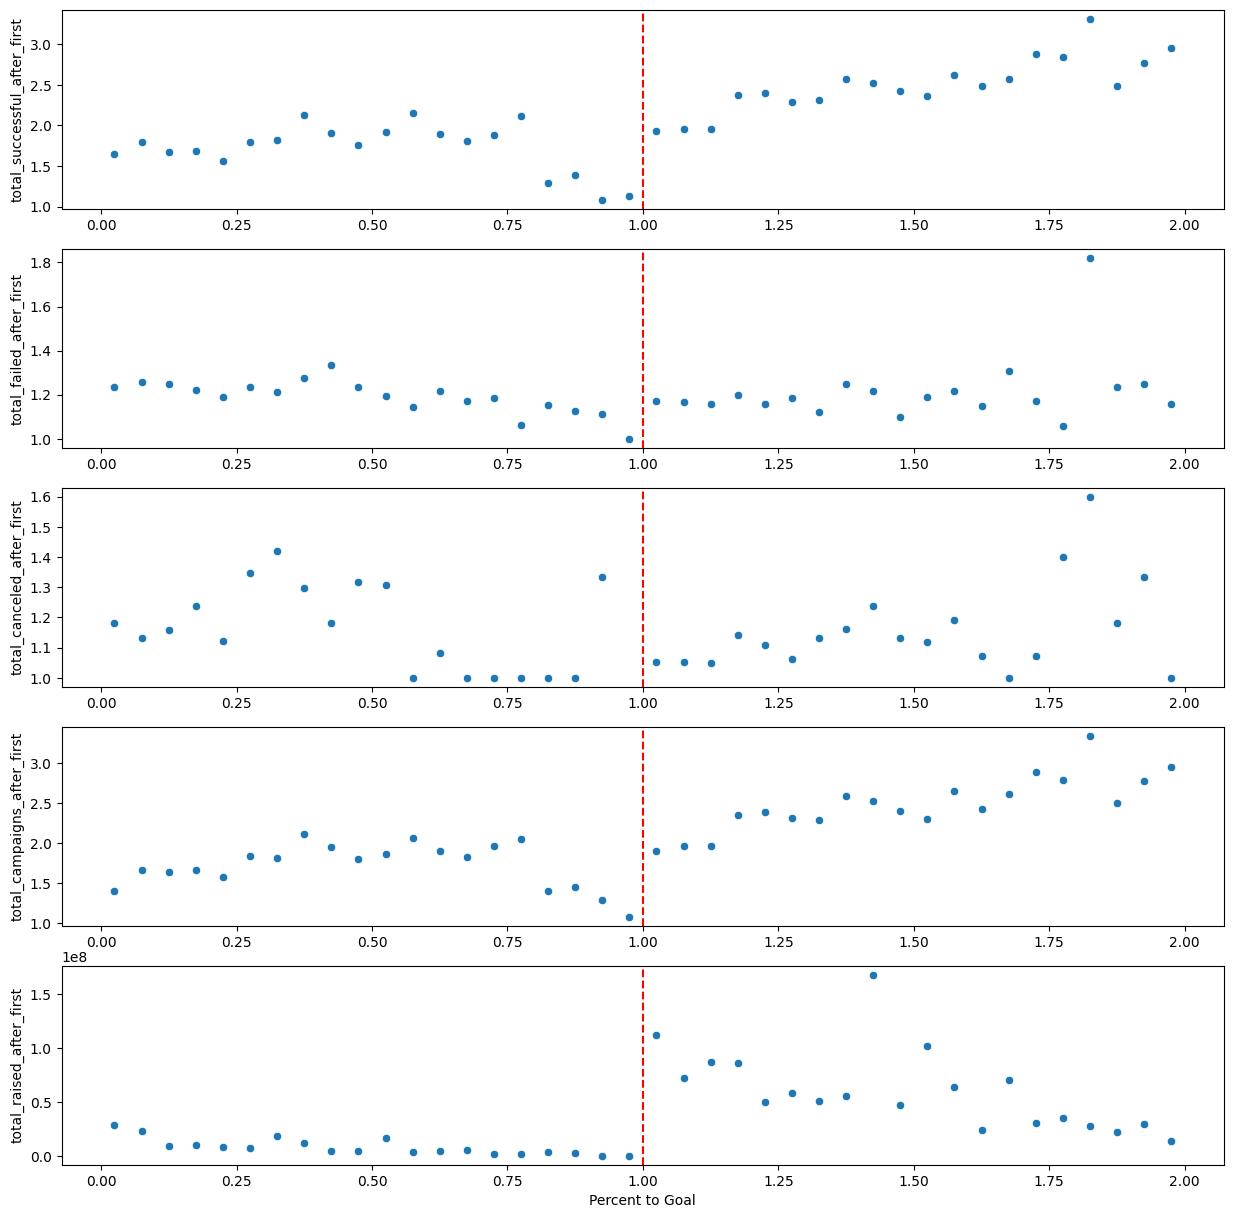

In [9]:
plt.figure(figsize=(15,15))
ax = plt.subplot(5, 1, 1)

sns.scatterplot(data=plotting_df, x = 'percent_to_goal', y = 'total_successful_after_first', ax = ax)
ax.axvline(x = 1, color = 'red', linestyle = '--')
ax.set_xlabel('')

ax = plt.subplot(5, 1, 2)
sns.scatterplot(data = plotting_df, x = 'percent_to_goal', y = 'total_failed_after_first', ax = ax)
ax.axvline(x = 1, color = 'red', linestyle = '--')
ax.set_xlabel('')

ax = plt.subplot(5, 1, 3)
sns.scatterplot(data = plotting_df, x = 'percent_to_goal', y = 'total_canceled_after_first', ax = ax)
ax.axvline(x = 1, color = 'red', linestyle = '--')
ax.set_xlabel('')

ax = plt.subplot(5, 1, 4)
sns.scatterplot(data = plotting_df, x = 'percent_to_goal', y = 'total_campaigns_after_first', ax = ax)
ax.axvline(x = 1, color = 'red', linestyle = '--')
ax.set_xlabel('')

ax = plt.subplot(5, 1, 5)
sns.scatterplot(data = plotting_df, x = 'percent_to_goal', y = 'total_raised_after_first', ax = ax)
ax.axvline(x = 1, color = 'red', linestyle = '--')
ax.set_xlabel('Percent to Goal')


In [10]:
plotting_df

,percent_to_goal_binned,total_successful_after_first,total_failed_after_first,total_canceled_after_first,total_raised_after_first,total_campaigns_after_first,n_obs,percent_to_goal,threshold
0,"(-0.001, 0.05]",1.648805,1.235171,1.180301,2.852479e+07,1.402621,80377,0.0245,False
1,"(0.05, 0.1]",1.793201,1.257709,1.130435,2.285252e+07,1.663172,15566,0.0750,False
2,"(0.1, 0.15]",1.677966,1.248016,1.157143,9.270335e+06,1.635342,9886,0.1250,False
3,"(0.15, 0.2]",1.688841,1.223188,1.238095,1.056213e+07,1.670199,6765,0.1750,False
4,"(0.2, 0.25]",1.563348,1.189474,1.121212,8.151370e+06,1.576071,5317,0.2250,False
5,"(0.25, 0.3]",1.800000,1.233831,1.346154,7.615889e+06,1.837338,3854,0.2750,False
6,"(0.3, 0.35]",1.823344,1.212329,1.421053,1.823006e+07,1.813901,3272,0.3250,False
7,"(0.35, 0.4]",2.134058,1.275229,1.296296,1.198105e+07,2.119444,2371,0.3750,False
8,"(0.4, 0.45]",1.901786,1.333333,1.181818,4.537201e+06,1.947735,1937,0.4250,False
9,"(0.45, 0.5]",1.761111,1.236842,1.315789,4.629892e+06,1.801653,1448,0.4750,False


# Discontinuity Analysis

In [11]:
rdd_df = df.assign(threshold = (df['percent_to_goal'] > 1).astype(int)).sort_values('percent_to_goal').reset_index(drop=True)
rdd_df['percent_to_goal*threshold'] = rdd_df['percent_to_goal'] * rdd_df['threshold']


Naive Model

In [12]:
model = smf.wls('total_successful_after_first ~ percent_to_goal + threshold + percent_to_goal*threshold', rdd_df).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.7093,0.068,25.081,0.000,1.576,1.843
percent_to_goal,0.1570,0.187,0.840,0.401,-0.209,0.523
threshold,0.9046,0.072,12.557,0.000,0.763,1.046
percent_to_goal:threshold,-0.1561,0.187,-0.836,0.403,-0.522,0.210


In [13]:
model = smf.wls('total_successful_after_first ~ percent_to_goal + threshold', rdd_df).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.7490,0.049,35.825,0.000,1.653,1.845
percent_to_goal,0.0008,0.000,3.329,0.001,0.000,0.001
threshold,0.8649,0.054,15.982,0.000,0.759,0.971


Text(0.5, 1.0, 'Regression Discontinuity')

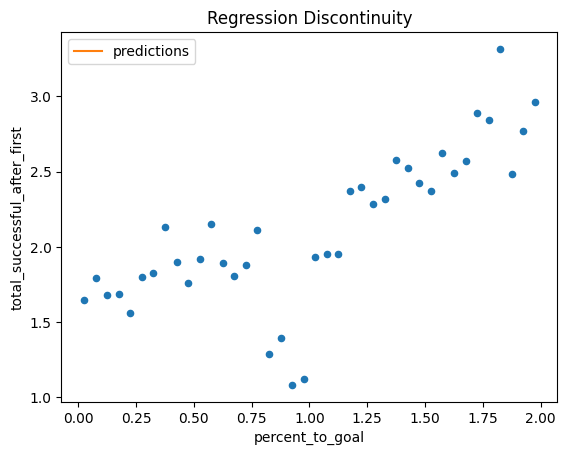

In [14]:
ax = plotting_df.plot.scatter(x = 'percent_to_goal', y = 'total_successful_after_first', color = "C0")
plotting_df.assign(predictions = model.fittedvalues).plot(x = 'percent_to_goal', y = 'predictions', color = 'C1', ax = ax)
plt.title('Regression Discontinuity')

Kernel weighted RD

In [15]:
def kernel(R, c, h):
    indicator = (np.abs(R - c) <= h).astype(float)
    return indicator * (1 - np.abs(R - c) / h)

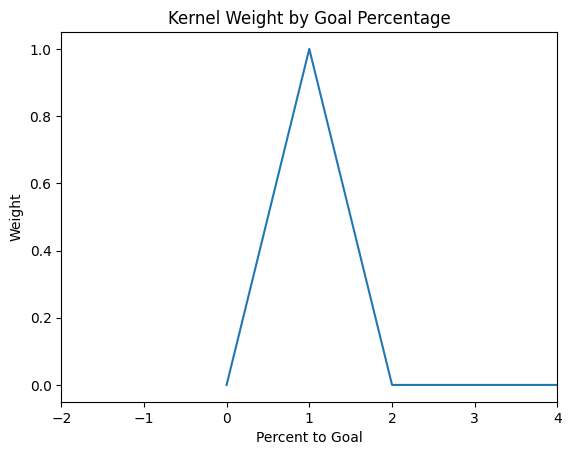

In [16]:
plt.plot(sorted(rdd_df["percent_to_goal"]), kernel(rdd_df["percent_to_goal"], c=1, h=1))
plt.xlabel("Percent to Goal")
plt.ylabel("Weight")
plt.xlim(-2, 4)
plt.title("Kernel Weight by Goal Percentage");

In [18]:
model = smf.wls("total_successful_after_first ~ percent_to_goal*threshold", data = rdd_df, weights = kernel(rdd_df['percent_to_goal'], c=1, h=1)).fit()

model.summary().tables[1]

c:\Users\d0tam\kickstarter-JMP\.venv\Lib\site-packages\statsmodels\regression\linear_model.py:806: RuntimeWarning: divide by zero encountered in log
  llf += 0.5 * np.sum(np.log(self.weights))


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.8638,0.111,16.835,0.000,1.647,2.081
percent_to_goal,-0.1386,0.184,-0.752,0.452,-0.500,0.223
threshold,-1.1222,0.172,-6.516,0.000,-1.460,-0.785
percent_to_goal:threshold,1.3393,0.214,6.246,0.000,0.919,1.760


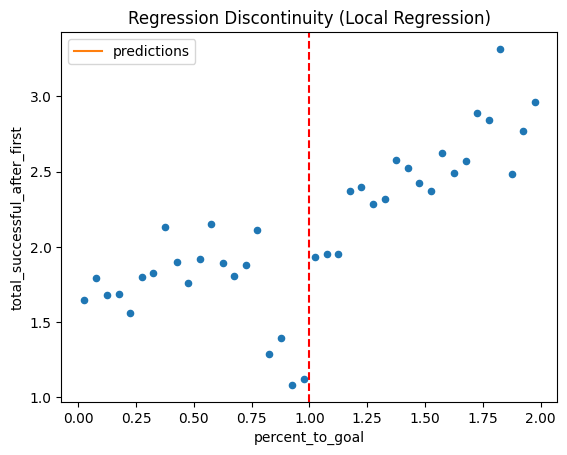

In [19]:
ax = plotting_df.plot.scatter(x="percent_to_goal", y="total_successful_after_first", color="C0")
plotting_df.assign(predictions=model.fittedvalues).plot(x="percent_to_goal", y="predictions", ax=ax, color="C1")
plt.axvline(x=1, color="red", linestyle="--")
plt.title("Regression Discontinuity (Local Regression)");

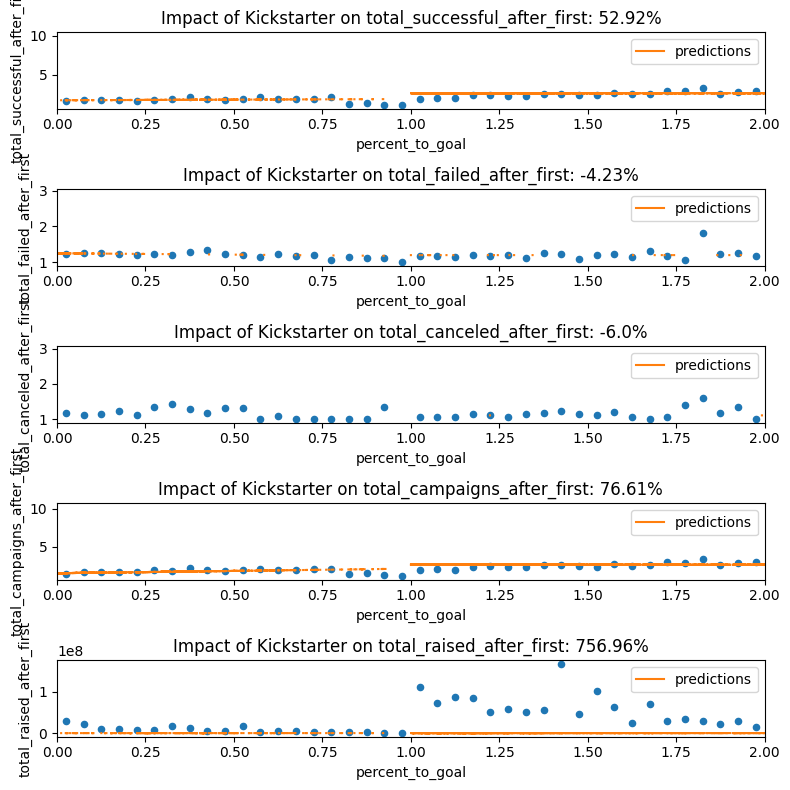

In [21]:
plt.figure(figsize=(8,8))

for p, cause in enumerate(["total_successful_after_first", "total_failed_after_first", "total_canceled_after_first", "total_campaigns_after_first", "total_raised_after_first"], 1):
    ax = plt.subplot(5,1,p)
    plotting_df.plot.scatter(x="percent_to_goal", y=cause, ax=ax)
    plt.xlim(0, 2)
    
    m = smf.wls(f"{cause}~percent_to_goal*threshold", rdd_df).fit()
    ate_pct = 100*((m.params["threshold"] + m.params["Intercept"])/m.params["Intercept"] - 1)
    rdd_df.assign(predictions=m.fittedvalues).plot(x="percent_to_goal", y="predictions", ax=ax, color="C1")
    plt.title(f"Impact of Kickstarter on {cause}: {np.round(ate_pct, 2)}%")

plt.tight_layout()

# McCrary Test

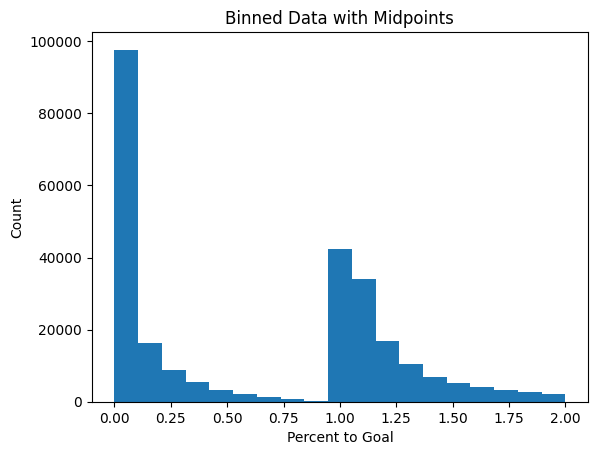

In [22]:
bins = np.linspace(0, 2, 20)

rdd_df['bin'] = pd.cut(rdd_df['percent_to_goal'], bins)

# Get Bin Counts
bin_counts = rdd_df['bin'].value_counts(sort = False)

# Calculate the midpoints for each bin
midpoints = bins[:-1] + (bins[1:] - bins[:-1]) / 2

# Plot the bar plot
plt.bar(midpoints, bin_counts, width=(bins[1] - bins[0]), align='center')
plt.xlabel('Percent to Goal')
plt.ylabel('Count')
plt.title('Binned Data with Midpoints')
plt.show()


# RD Analysis with Optimal Bandwidth (IK)

Set Thresholds

In [23]:
perc_threshold = 1
abs_threshold = 0

Identify Optimal Bandwidth

In [24]:
bandwidth_opt_perc = rdd.optimal_bandwidth(X = rdd_df['percent_to_goal'], Y = rdd_df['total_successful_after_first'], cut=perc_threshold)
bandwidth_opt_abs = rdd.optimal_bandwidth(X = rdd_df['dollars_to_goal'], Y = rdd_df['total_successful_after_first'], cut=abs_threshold)
print("Optimal Percentage bandwidth:", bandwidth_opt_perc)
print("Optimal Absolute bandwidth:", bandwidth_opt_abs)

Optimal Percentage bandwidth: 0.4400109204309762
Optimal Absolute bandwidth: 11.485762947405044


Restrict Data to Optimal Bandwidth

In [25]:
perc_rdd_df = rdd.truncated_data(rdd_df, 'percent_to_goal', bandwidth_opt_perc, cut=perc_threshold)

#abs_rdd_df = rdd.truncated_data(rdd_df, 'dollars_to_goal', bandwidth_opt_abs, cut=abs_threshold)
abs_rdd_df = rdd.truncated_data(rdd_df, 'dollars_to_goal', 1000, cut=abs_threshold)

print(f"Percentage RDD Shape: {perc_rdd_df.shape}")
print(f"Absolute RDD Shape: {abs_rdd_df.shape}")



Percentage RDD Shape: (112013, 141)
Absolute RDD Shape: (116453, 141)


## Dollars to Goal

In [27]:
model = smf.wls("total_successful_after_first ~ dollars_to_goal*threshold", data = abs_rdd_df, weights = kernel(abs_rdd_df['dollars_to_goal'], c=abs_threshold, h=bandwidth_opt_abs)).fit()

model.summary().tables[1]


c:\Users\d0tam\kickstarter-JMP\.venv\Lib\site-packages\statsmodels\regression\linear_model.py:806: RuntimeWarning: divide by zero encountered in log
  llf += 0.5 * np.sum(np.log(self.weights))


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.6708,0.060,27.675,0.000,1.553,1.789
dollars_to_goal,-0.1265,0.168,-0.752,0.452,-0.456,0.203
threshold,1.1821,0.115,10.324,0.000,0.958,1.407
dollars_to_goal:threshold,0.2045,0.170,1.205,0.228,-0.128,0.537


In [28]:
ate_pct = 100*((model.params["threshold"] + model.params["Intercept"])/model.params["Intercept"] - 1)
print(f"Impact of Winning First Kickstarter on Total Successful Projects: {np.round(ate_pct, 2)}%")

Impact of Winning First Kickstarter on Total Successful Projects: 70.75%


## Percent to Goal

In [26]:
model = smf.wls("total_successful_after_first ~ percent_to_goal*threshold", data = perc_rdd_df, weights = kernel(perc_rdd_df['percent_to_goal'], c=perc_threshold, h=bandwidth_opt_perc)).fit()

model.summary().tables[1]


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.2882,0.934,2.449,0.014,0.457,4.120
percent_to_goal,-0.6811,1.013,-0.673,0.501,-2.666,1.304
threshold,-2.0213,1.006,-2.009,0.045,-3.994,-0.049
percent_to_goal:threshold,2.3102,1.068,2.164,0.030,0.218,4.403


In [29]:
ate_pct = 100*((model.params["threshold"] + model.params["Intercept"])/model.params["Intercept"] - 1)
print(f"Impact of Winning First Kickstarter on Total Successful Projects: {np.round(ate_pct, 2)}%")

Impact of Winning First Kickstarter on Total Successful Projects: 70.75%
